# Imports

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import scikitplot as skplt

import xgboost as xgb

import sklearn.metrics
import pickle

from IPython.core.display import HTML
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper functions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import sys 
path_to_module = '/content/drive/MyDrive/health_insurance_cross_sell-main/health_insurance_cross_sell'
sys.path.append(path_to_module)

In [ ]:
from functions import performace, recall_at_k

# Load data

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/health_insurance_cross_sell-main/health_insurance_cross_sell/data/test_raw.csv')


In [ ]:
test_df.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,vehicle_age,vehicle_damage,response
0,196319,Male,50,33.0,124.0,0,40841.0,154,> 2 Years,1,0
1,377373,Male,40,8.0,124.0,1,2630.0,145,1-2 Year,0,0
2,96687,Female,65,41.0,109.0,0,26336.0,246,1-2 Year,1,0
3,303533,Male,60,28.0,124.0,0,52717.0,139,1-2 Year,1,0
4,256233,Male,36,36.0,26.0,0,39176.0,73,1-2 Year,1,1


In [ ]:
test_df.shape

(114090, 11)

In [ ]:
test_df.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
vehicle_age              object
vehicle_damage            int64
response                  int64
dtype: object

# Data Preparation

In [ ]:
df8 = test_df.copy()

In [ ]:
mms_age = pickle.load(open('/content/drive/MyDrive/health_insurance_cross_sell-main/health_insurance_cross_sell/features/age_scaler.pkl','rb'))
mms_vintage = pickle.load(open('/content/drive/MyDrive/health_insurance_cross_sell-main/health_insurance_cross_sell/features/vintage_scaler.pkl','rb'))
se = pickle.load(open('/content/drive/MyDrive/health_insurance_cross_sell-main/health_insurance_cross_sell/features/annual_premium_scaler.pkl','rb'))


## rescaling

In [ ]:
# Min - max sacaler
df8['age'] = mms_age.transform(df8[['age']].values)

df8['vintage'] = mms_vintage.transform(df8[['vintage']].values)

# StandardScale
df8['annual_premium'] = se.transform(df8[['annual_premium']].values)

## encoding

In [ ]:
df8['gender'] = df8['gender'].apply(lambda x: 1 if x=='Female' else (0 if x=='Male' else x))


# vehicle_age ordinal scale
vehicle_age_dict = {'> 2 Years':3, '1-2 Year':2, '< 1 Year':1}
df8['vehicle_age'] = df8['vehicle_age'].map(vehicle_age_dict)



In [ ]:
final_columns = ['id',  'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'vehicle_age',
       'vehicle_damage', 'response']

In [ ]:
df8 = df8[final_columns]

# Model

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/health_insurance_cross_sell-main/health_insurance_cross_sell/models/xgb_model_final.pkl','rb'))

In [ ]:
X_test = df8.copy()
y_test = X_test['response']
X_test.drop(columns=['id','response'],inplace = True)

In [ ]:
#model prediction proba - poder de generalização
yhat_proba = model.predict_proba( X_test )

#model prediction - poder de generalização
yhat_class = model.predict( X_test )

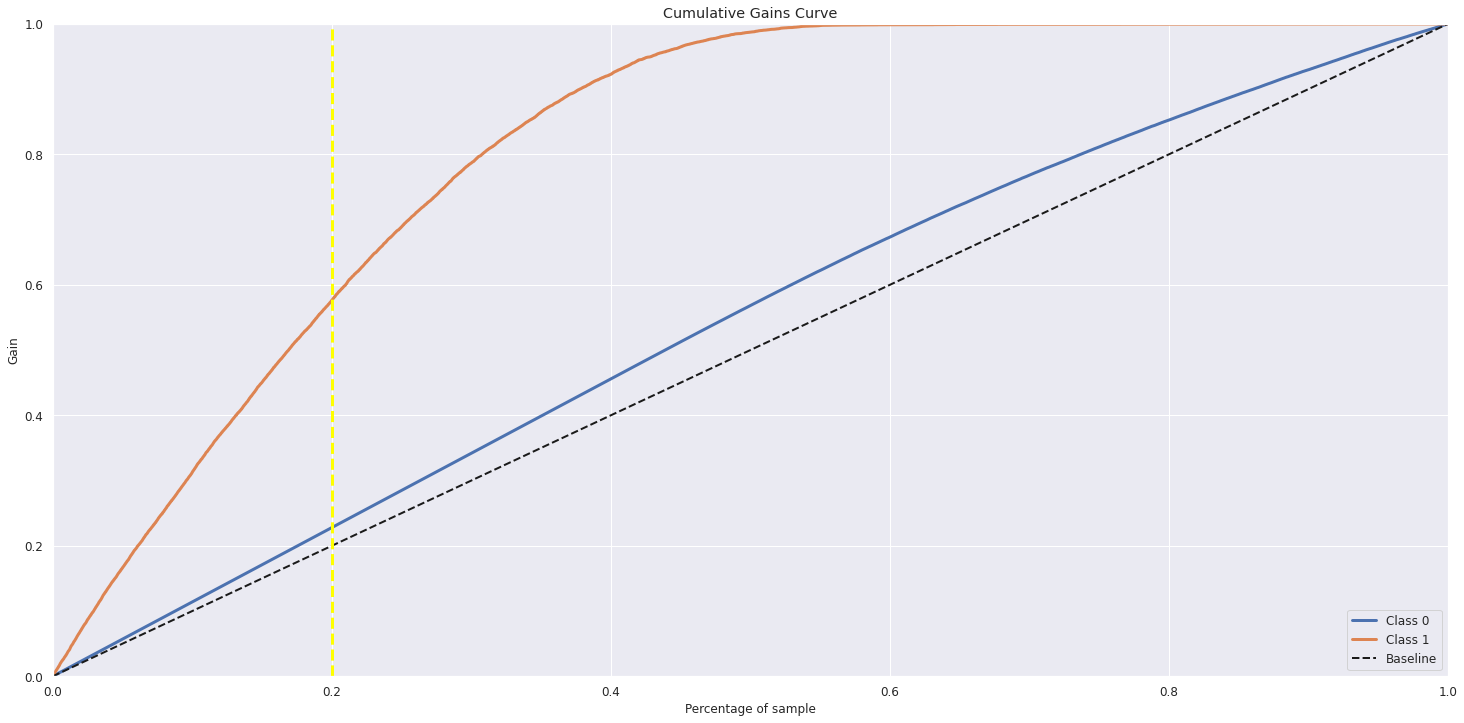

In [ ]:
skplt.metrics.plot_cumulative_gain(y_test,yhat_proba);
plt.axvline(0.2, 0, 1, color='yellow', ls='--', lw=3)

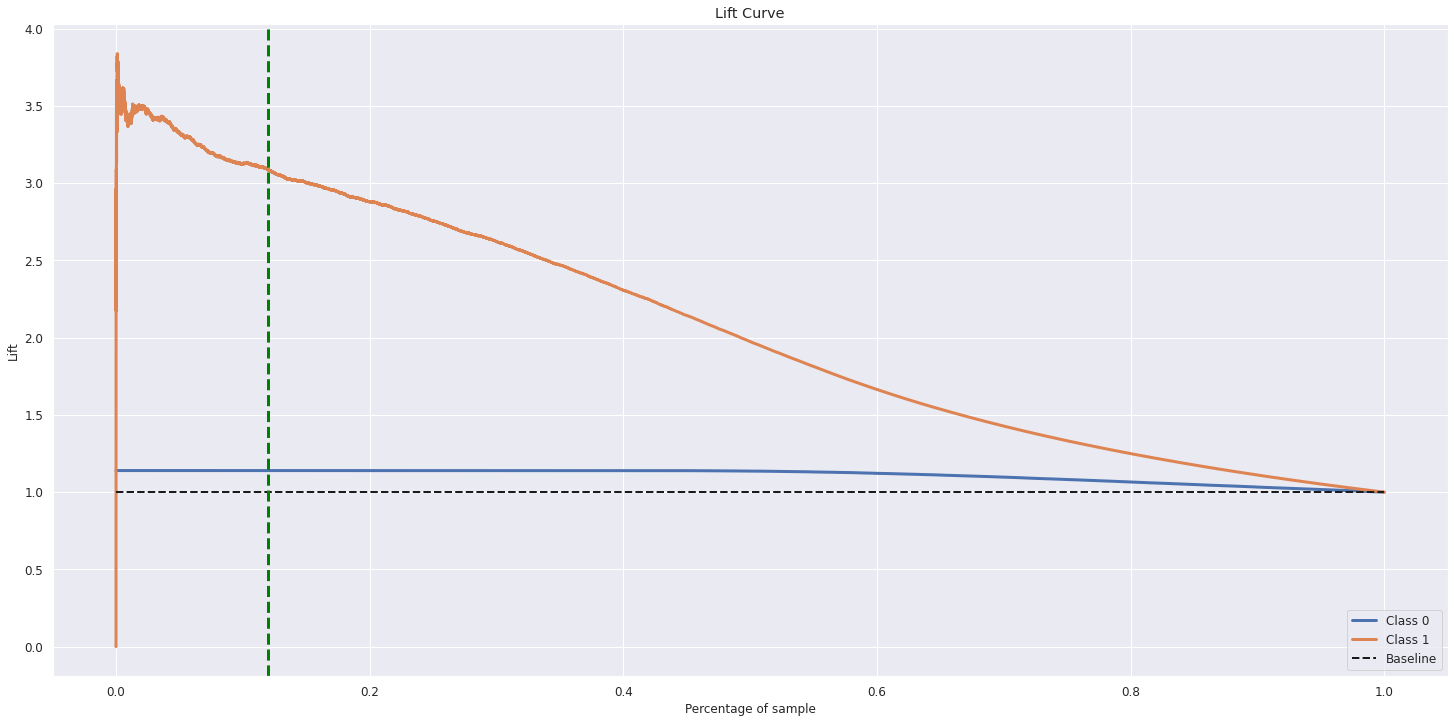

In [ ]:
skplt.metrics.plot_lift_curve(y_test,yhat_proba);
plt.axvline(0.12, 0, 1, color='green', ls='--', lw=3)

In [ ]:
model_df = test_df.copy()
model_df['model_score'] = yhat_proba[:,1].tolist()
# sorte by score
model_df = model_df.sort_values('model_score',ascending=False)

In [ ]:
model_df

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,vehicle_age,vehicle_damage,response,model_score
112906,247986,Male,34,28.0,124.0,0,90941.0,164,1-2 Year,1,0,0.747272
51525,299944,Male,39,18.0,124.0,0,134092.0,195,1-2 Year,1,0,0.739605
51094,139716,Female,53,28.0,124.0,0,133280.0,203,> 2 Years,1,0,0.711632
92549,232888,Male,54,28.0,26.0,0,132387.0,240,1-2 Year,1,0,0.695620
20598,334982,Male,59,51.0,157.0,0,132401.0,135,1-2 Year,1,1,0.657332
...,...,...,...,...,...,...,...,...,...,...,...,...
60522,318790,Female,20,25.0,160.0,1,2630.0,102,< 1 Year,0,0,0.000054
97963,103815,Female,20,9.0,160.0,1,2630.0,162,< 1 Year,0,0,0.000054
18918,309675,Male,21,8.0,160.0,1,78883.0,31,< 1 Year,0,0,0.000052
11819,76357,Female,20,28.0,160.0,1,91487.0,282,< 1 Year,0,0,0.000051


# Questões de negócio

## Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

In [ ]:
clients = 20000
perct= round(recall_at_k(model_df,clients)*100,2)

In [ ]:
print('Com ' + str(clients) + ' mil ligações o time de vendas atingirá '+str(perct) + "% dos clientes interresados em toda base disponível, considerando que ao total se tem " + str(len(model_df)) + 
      " mil de possíveis clientes, "+str(clients)+" represanta apenas " + str(round((clients/len(model_df))*100,2)) + "% do total, ou seja, ligando para menos de um quinto da base de dados é possivel atingir mais da metade dos possivelmente interresados ")

Com 20000 mil ligações o time de vendas atingirá 51.62% dos clientes interresados em toda base disponível, considerando que ao total se tem 114090 mil de possíveis clientes, 20000 represanta apenas 17.53% do total, ou seja, ligando para menos de um quinto da base de dados é possivel atingir mais da metade dos possivelmente interresados 


In [ ]:
random_model = int((clients/len(model_df)) * y_test.value_counts()[1])
xgb_model = int(recall_at_k(model_df,clients) * y_test.value_counts()[1])
mean_annual = round(model_df['annual_premium'].mean(),2)
dollar_annual = round(mean_annual * 0.012,2)

In [ ]:
print("Utilizando o modelo aleátorio, que poderia ser só uma seleção aleátoria dos clientes ou uma simples ordenação por algum atributo, ligando para " +str(clients) + " clientes atingiriamos apenas " + str(random_model) + " dos " + str(y_test.value_counts()[1]) +" clientes interresados, já como o nosso modelo atingimos " +
str(xgb_model) + ", assim, captando " + str(round(xgb_model/random_model,2),) + " vezes mais potênciais clientes do segundo seguro.")

Utilizando o modelo aleátorio, que poderia ser só uma seleção aleátoria dos clientes ou uma simples ordenação por algum atributo, ligando para 20000 clientes atingiriamos apenas 2454 dos 14001 clientes interresados, já como o nosso modelo atingimos 7227, assim, captando 2.94 vezes mais potênciais clientes do segundo seguro.


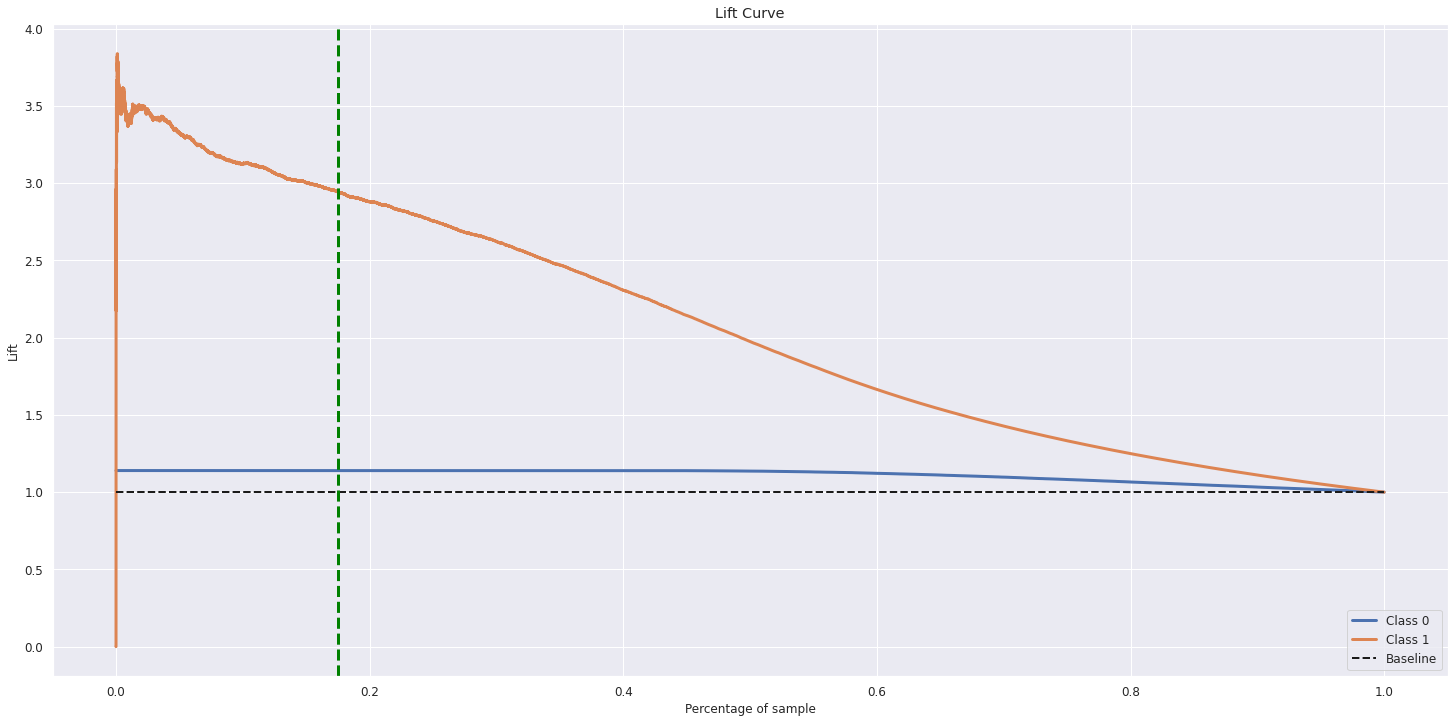

In [ ]:
skplt.metrics.plot_lift_curve(y_test,yhat_proba);
plt.axvline(clients/len(model_df), 0, 1, color='green', ls='--', lw=3)

In [ ]:
print("Em termos monetários, levando em consideração que a média do plano anual é de " + str(mean_annual) + " Rupias indianas, que convertendo para dólar daria por volta de " + str(dollar_annual) + " Doláres.")
print("Com o model aleátorio teriamos um retorno de U$ {:,}".format(random_model*dollar_annual)) 
print("Com o model criado teriamos um retorno de U$ {:,}".format(xgb_model*dollar_annual)) 

Em termos monetários, levando em consideração que a média do plano anual é de 30541.6 Rupias indianas, que convertendo para dólar daria por volta de 366.5 Doláres.
Com o model aleátorio teriamos um retorno de U$ 899,391.0
Com o model criado teriamos um retorno de U$ 2,648,695.5


# E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

In [ ]:
clients = 40000
perct= round(recall_at_k(model_df,clients)*100,2)

In [ ]:
print('Com ' + str(clients) + ' mil ligações o time de vendas atingirá '+str(perct) + "% dos clientes interresados em toda base disponível, considerando que ao total se tem " + str(len(model_df)) + 
      " mil de possíveis clientes, "+str(clients)+" represanta apenas " + str(round((clients/len(model_df))*100,2)) + "% do total, ou seja, ligando pouco mais de um terço da base de dados é possivel atingir a grande maioria dos clientes possivelmente interresados ")

Com 40000 mil ligações o time de vendas atingirá 86.57% dos clientes interresados em toda base disponível, considerando que ao total se tem 114090 mil de possíveis clientes, 40000 represanta apenas 35.06% do total, ou seja, ligando pouco mais de um terço da base de dados é possivel atingir a grande maioria dos clientes possivelmente interresados 


In [ ]:
print('Com ' + str(clients) + ' mil ligações o time de vendas atingirá '+str(perct) + "% dos clientes interresados em toda base disponível, considerando que ao total se tem " + str(len(model_df)) + 
      " mil de possíveis clientes, "+str(clients)+" represanta apenas " + str(round((clients/len(model_df))*100,2)) + "% do total, ou seja, ligando para menos de um quinto da base de dados é possivel atingir mais da metade dos possivelmente interresados ")

Com 40000 mil ligações o time de vendas atingirá 86.57% dos clientes interresados em toda base disponível, considerando que ao total se tem 114090 mil de possíveis clientes, 40000 represanta apenas 35.06% do total, ou seja, ligando para menos de um quinto da base de dados é possivel atingir mais da metade dos possivelmente interresados 


In [ ]:
random_model = int((clients/len(model_df)) * y_test.value_counts()[1])
xgb_model = int(recall_at_k(model_df,clients) * y_test.value_counts()[1])
mean_annual = round(model_df['annual_premium'].mean(),2)
dollar_annual = round(mean_annual * 0.012,2)

In [ ]:
print("Utilizando o modelo aleátorio, que poderia ser só uma seleção aleátoria dos clientes ou uma simples ordenação por algum atributo, ligando para " +str(clients) + " clientes atingiriamos apenas " + str(random_model) + " dos " + str(y_test.value_counts()[1]) +" clientes interresados, já como o nosso modelo atingimos " +
str(xgb_model) + ", assim, captando " + str(round(xgb_model/random_model,2),) + " vezes mais potênciais clientes do segundo seguro.")

Utilizando o modelo aleátorio, que poderia ser só uma seleção aleátoria dos clientes ou uma simples ordenação por algum atributo, ligando para 40000 clientes atingiriamos apenas 4908 dos 14001 clientes interresados, já como o nosso modelo atingimos 12121, assim, captando 2.47 vezes mais potênciais clientes do segundo seguro.


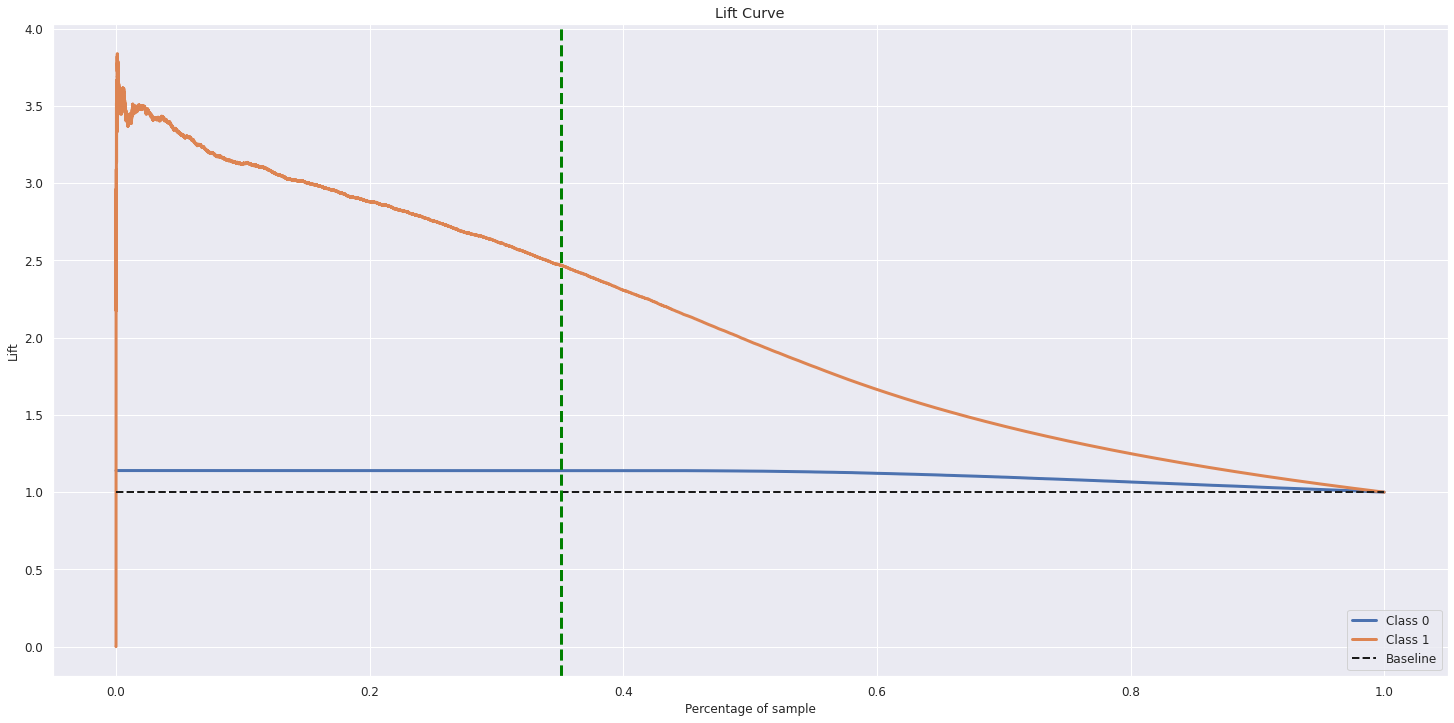

In [ ]:
skplt.metrics.plot_lift_curve(y_test,yhat_proba);
plt.axvline(clients/len(model_df), 0, 1, color='green', ls='--', lw=3)

In [ ]:
print("Em termos monetários, levando em consideração que a média do plano anual é de " + str(mean_annual) + " Rupias indianas, que convertendo para dólar daria por volta de " + str(dollar_annual) + " Doláres.")
print("Com o model aleátorio teriamos um retorno de U$ {:,}".format(random_model*dollar_annual)) 
print("Com o model criado teriamos um retorno de U$ {:,}".format(xgb_model*dollar_annual)) 

Em termos monetários, levando em consideração que a média do plano anual é de 30541.6 Rupias indianas, que convertendo para dólar daria por volta de 366.5 Doláres.
Com o model aleátorio teriamos um retorno de U$ 1,798,782.0
Com o model criado teriamos um retorno de U$ 4,442,346.5


##  Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

In [ ]:
clients = 35097
perct = round(recall_at_k(model_df,clients)*100,2)

In [ ]:
print('Com ' + str(clients) + ' mil ligações o time de vendas atingirá '+str(perct) + "% dos clientes interresados em toda base disponível, considerando que ao total se tem " + str(len(model_df)) + 
      " mil de possíveis clientes, "+str(clients)+" represanta apenas " + str(round((clients/len(model_df))*100,2)) + "% do total, ou seja, ligando para menos de um terço da base de dados é possivel atingir a grande maioria dos clientes possivelmente interresados")

Com 35097 mil ligações o time de vendas atingirá 80.0% dos clientes interresados em toda base disponível, considerando que ao total se tem 114090 mil de possíveis clientes, 35097 represanta apenas 30.76% do total, ou seja, ligando para menos de um terço da base de dados é possivel atingir a grande maioria dos clientes possivelmente interresados


In [ ]:
print('Com ' + str(clients) + ' mil ligações o time de vendas atingirá '+str(perct) + "% dos clientes interresados em toda base disponível, considerando que ao total se tem " + str(len(model_df)) + 
      " mil de possíveis clientes, "+str(clients)+" represanta apenas " + str(round((clients/len(model_df))*100,2)) + "% do total, ou seja, ligando para menos de um quinto da base de dados é possivel atingir mais da metade dos possivelmente interresados ")

Com 35097 mil ligações o time de vendas atingirá 80.0% dos clientes interresados em toda base disponível, considerando que ao total se tem 114090 mil de possíveis clientes, 35097 represanta apenas 30.76% do total, ou seja, ligando para menos de um quinto da base de dados é possivel atingir mais da metade dos possivelmente interresados 


In [ ]:
random_model = int((clients/len(model_df)) * y_test.value_counts()[1])
xgb_model = int(recall_at_k(model_df,clients) * y_test.value_counts()[1])
mean_annual = round(model_df['annual_premium'].mean(),2)
dollar_annual = round(mean_annual * 0.012,2)

In [ ]:
print("Utilizando o modelo aleátorio, que poderia ser só uma seleção aleátoria dos clientes ou uma simples ordenação por algum atributo, ligando para " +str(clients) + " clientes atingiriamos apenas " + str(random_model) + " dos " + str(y_test.value_counts()[1]) +" clientes interresados, já como o nosso modelo atingimos " +
str(xgb_model) + ", assim, captando " + str(round(xgb_model/random_model,2),) + " vezes mais potênciais clientes do segundo seguro.")

Utilizando o modelo aleátorio, que poderia ser só uma seleção aleátoria dos clientes ou uma simples ordenação por algum atributo, ligando para 35097 clientes atingiriamos apenas 4307 dos 14001 clientes interresados, já como o nosso modelo atingimos 11201, assim, captando 2.6 vezes mais potênciais clientes do segundo seguro.


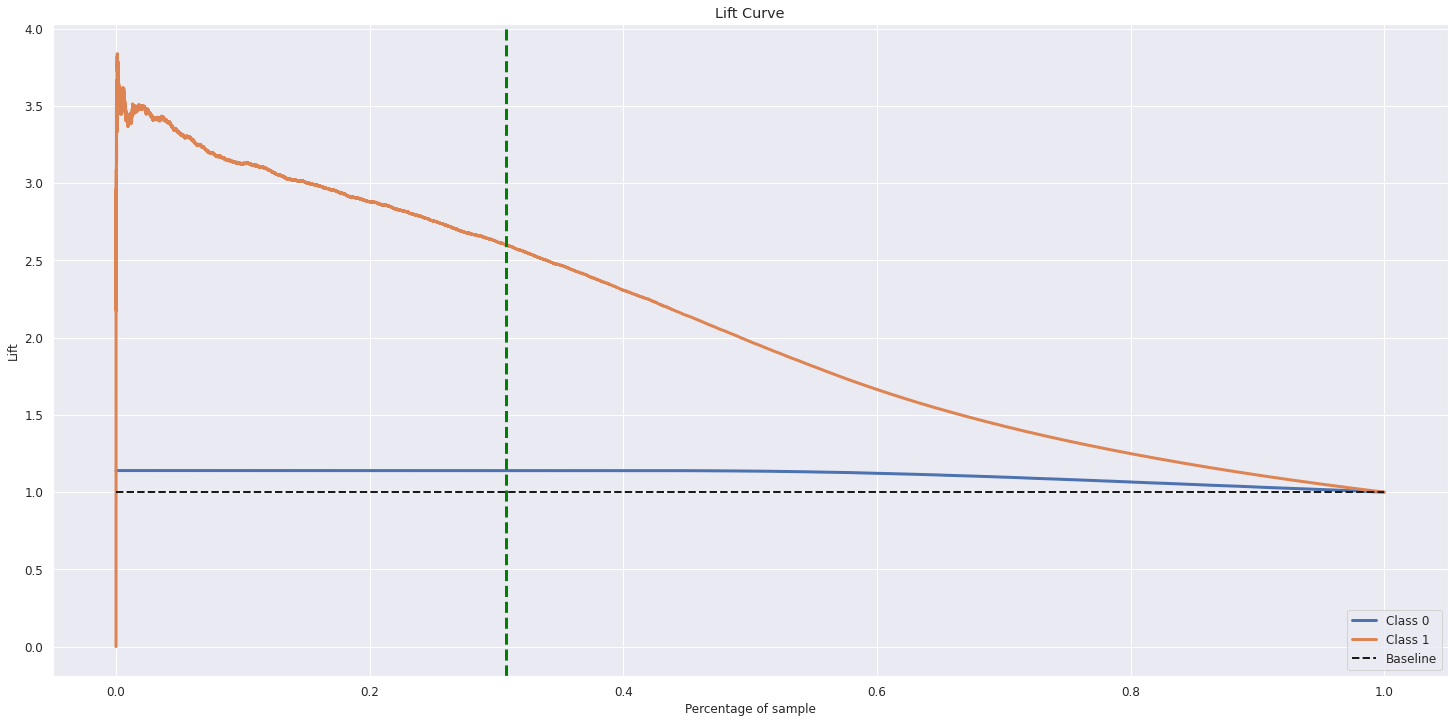

In [ ]:
skplt.metrics.plot_lift_curve(y_test,yhat_proba);
plt.axvline(clients/len(model_df), 0, 1, color='green', ls='--', lw=3)

In [ ]:
print("Em termos monetários, levando em consideração que a média do plano anual é de " + str(mean_annual) + " Rupias indianas, que convertendo para dólar daria por volta de " + str(dollar_annual) + " Doláres.")
print("Com o model aleátorio teriamos um retorno de U$ {:,}".format(random_model*dollar_annual)) 
print("Com o model criado teriamos um retorno de U$ {:,}".format(xgb_model*dollar_annual)) 

Em termos monetários, levando em consideração que a média do plano anual é de 30541.6 Rupias indianas, que convertendo para dólar daria por volta de 366.5 Doláres.
Com o model aleátorio teriamos um retorno de U$ 1,578,515.5
Com o model criado teriamos um retorno de U$ 4,105,166.5
